In [115]:
import pandas
import numpy

In [2]:
import pandas as pd
from datetime import datetime

# Define the column names as provided
column_names = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Load the data with proper column names
df = pd.read_csv('data/data.txt', sep=' ', header=None, names=column_names)

# Function to parse the time with fallback for different formats
def parse_time(time_str):
    try:
        return datetime.strptime(time_str, '%H:%M:%S.%f').time()
    except ValueError:
        try:
            return datetime.strptime(time_str, '%H:%M:%S').time()
        except ValueError:
            return None

# Apply the function to the 'time' column
df['time'] = df['time'].apply(parse_time)

# Ensure the 'date' column is parsed correctly
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Ensure correct data types for other columns
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').astype('Int64')
df['moteid'] = pd.to_numeric(df['moteid'], errors='coerce').astype('Int64')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['light'] = pd.to_numeric(df['light'], errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')

# Print the last few rows of the dataframe to verify
print(df.tail())

# Optionally, handle any rows where the date or time could not be parsed
invalid_dates = df[df['date'].isna()]
invalid_times = df[df['time'].isna()]

print("Rows with invalid dates:")
print(invalid_dates)

print("Rows with invalid times:")
print(invalid_times)


               date             time  epoch  moteid  temperature  humidity  \
2313677  2004-04-02  01:14:54.164318  61274    <NA>          NaN       NaN   
2313678  2004-04-02  01:17:53.670524  61275    <NA>          NaN       NaN   
2313679  2004-04-02  01:20:52.807972  61276    <NA>          NaN       NaN   
2313680  2004-04-02  01:26:53.950342  61278    <NA>          NaN       NaN   
2313681  2004-04-02  01:35:53.897412  61280    <NA>          NaN       NaN   

         light  voltage  
2313677    NaN      NaN  
2313678    NaN      NaN  
2313679    NaN      NaN  
2313680    NaN      NaN  
2313681    NaN      NaN  
Rows with invalid dates:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []
Rows with invalid times:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []


In [3]:
df = df.dropna()

# Print the last few rows of the dataframe to verify
len(df)

2219803

In [4]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Parse the 'time' column dynamically
df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S.%f').dt.time
df['time'] = df['time'].fillna(pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S').dt.time)

In [5]:
# Remove rows where 'time' could not be parsed (NaT values)
df = df.dropna(subset=['time'])

In [6]:
# Combine 'date' and 'time' into a single 'datetime' column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

In [7]:
df = df[df['temperature'] <= 35]

In [8]:
df.describe()

,date,epoch,moteid,temperature,humidity,light,voltage,datetime
count,1812035,1812035.0,1812035.0,1.812035e+06,1.812035e+06,1.812035e+06,1.812035e+06,1812035
mean,2004-03-09 15:06:16.019889152,30149.362869,28.897668,2.201539e+01,3.926629e+01,4.089363e+02,2.556051e+00,2004-03-10 03:09:40.850130816
min,2004-02-28 00:00:00,0.0,1.0,-3.840000e+01,-8.983130e+03,0.000000e+00,1.803690e-02,2004-02-28 00:58:46.002832
25%,2004-03-04 00:00:00,14288.0,17.0,1.998840e+01,3.536870e+01,3.956000e+01,2.474670e+00,2004-03-04 04:21:02.689847040
50%,2004-03-09 00:00:00,28460.0,30.0,2.179160e+01,4.039900e+01,1.582400e+02,2.582260e+00,2004-03-09 02:07:50.318541056
75%,2004-03-15 00:00:00,44843.0,43.0,2.360460e+01,4.385150e+01,5.667200e+02,2.639640e+00,2004-03-15 10:20:17.476448
max,2004-04-05 00:00:00,65535.0,58.0,3.499220e+01,1.148940e+02,1.847360e+03,3.159150e+00,2004-04-05 11:02:32.715337
std,NaN,18581.495896,15.360598,3.599409e+00,9.733649e+00,5.407553e+02,1.181588e-01,NaN


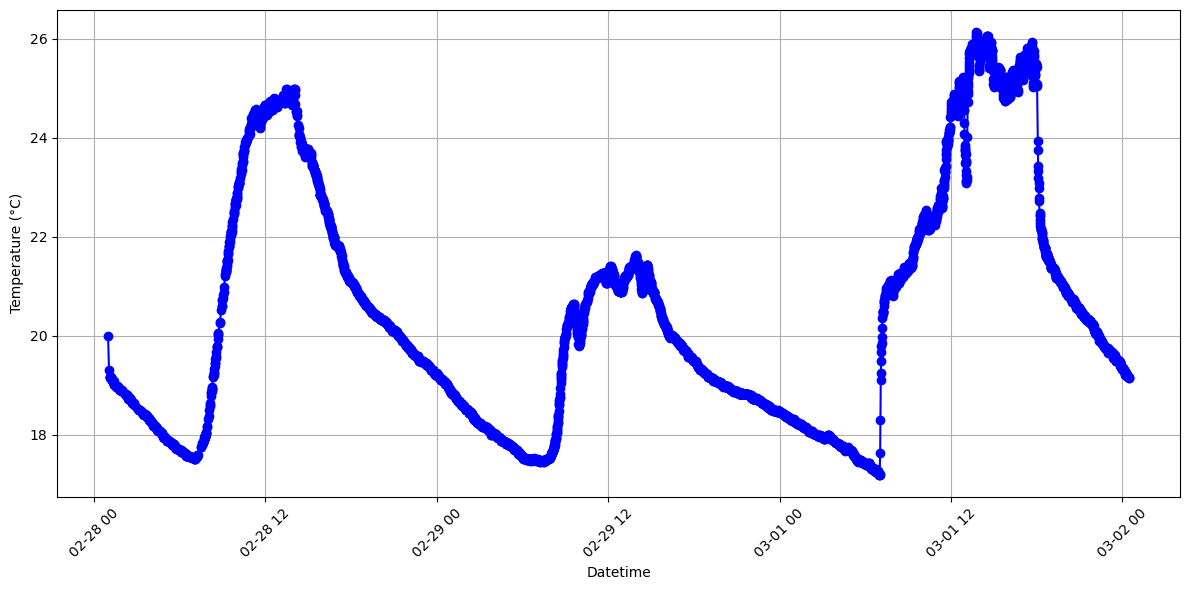

In [10]:
# Filter the top 20 rows
top_df =df.head(5000)
# Plot datetime vs temperature for the top 20 rows
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(top_df['datetime'], top_df['temperature'], marker='o', linestyle='-', color='b')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

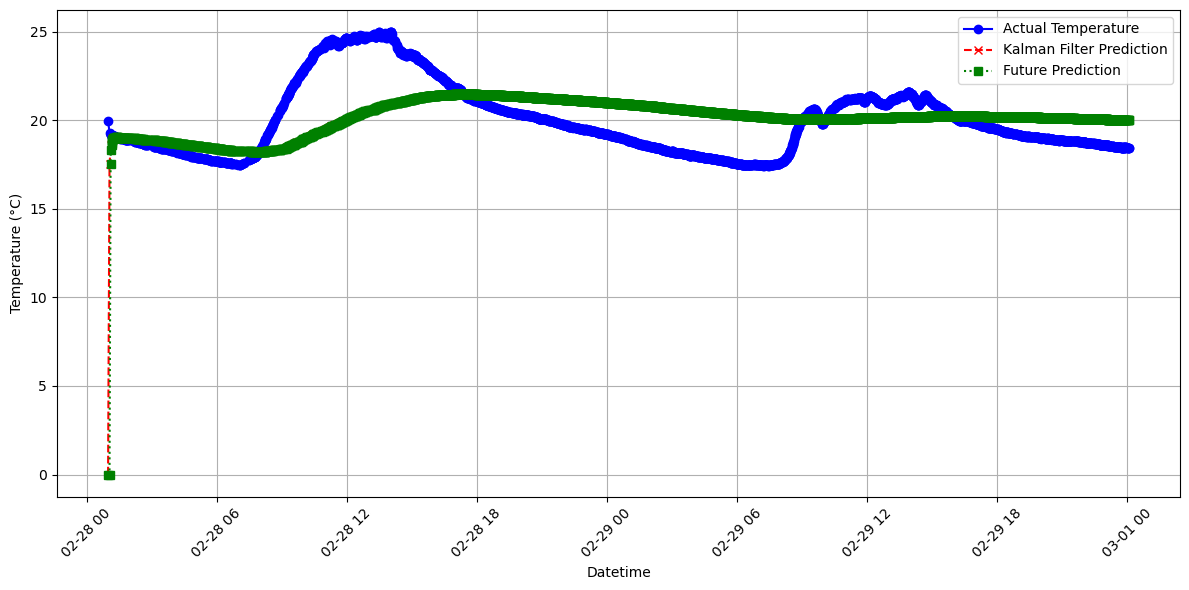

Average MSE: 3.8946552027115344
Total number of temperature readings: 3049
Number of eventful predictions: 3005


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 3050 rows
top_150_df = df.head(3050)

# Parameters
A = 1       # State transition matrix
H = 1       # Measurement matrix
Q = 0       # Process noise covariance
R = 0.1       # Measurement noise covariance
x_hat = 0  # Initial state estimate (initial temperature)
P = 1       # Initial estimate covariance
epsilon = 0.05  # Sensitivity threshold for event detection

# Kalman Filter Implementation
estimated = np.zeros(len(top_150_df))
predicted_future = np.zeros(len(top_150_df))
estimated[0] = x_hat

# Store the timestamps for plotting
timestamps = top_150_df['datetime'].values

# Initialize counters
total_readings = 0
eventful_readings = 0

# Apply the Kalman filter to the temperature readings
for i in range(1, len(top_150_df)):
    # Current measurement
    z = top_150_df['temperature'].iloc[i]

    # Prediction
    xp = A * x_hat
    Pp = A * P * A + Q

    # Store the future prediction before updating
    predicted_future[i] = xp

    # Update
    K = Pp * H / (H * Pp * H + R)
    x_hat = xp + K * (z - H * xp)
    P = Pp - K * H * Pp

    # Store the estimate
    estimated[i] = x_hat

    # Increment total readings count
    total_readings += 1

    # Check for eventful predictions by comparing the predicted value with the last received value
    if abs(predicted_future[i] - top_150_df['temperature'].iloc[i-1]) > epsilon:
        eventful_readings += 1

# Plot the actual temperature, the Kalman filter predictions, and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(timestamps, top_150_df['temperature'], label='Actual Temperature', marker='o', linestyle='-', color='blue')
plt.plot(timestamps, estimated, label='Kalman Filter Prediction', marker='x', linestyle='--', color='red')
plt.plot(timestamps, predicted_future, label='Future Prediction', marker='s', linestyle=':', color='green')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print the Mean Squared Error (MSE)
mse = np.mean((top_150_df['temperature'].values - estimated) ** 2)
print(f'Average MSE: {mse}')

# Print the total number of temperature readings and the number of eventful predictions
print("Total number of temperature readings:", total_readings)
print("Number of eventful predictions:", eventful_readings)


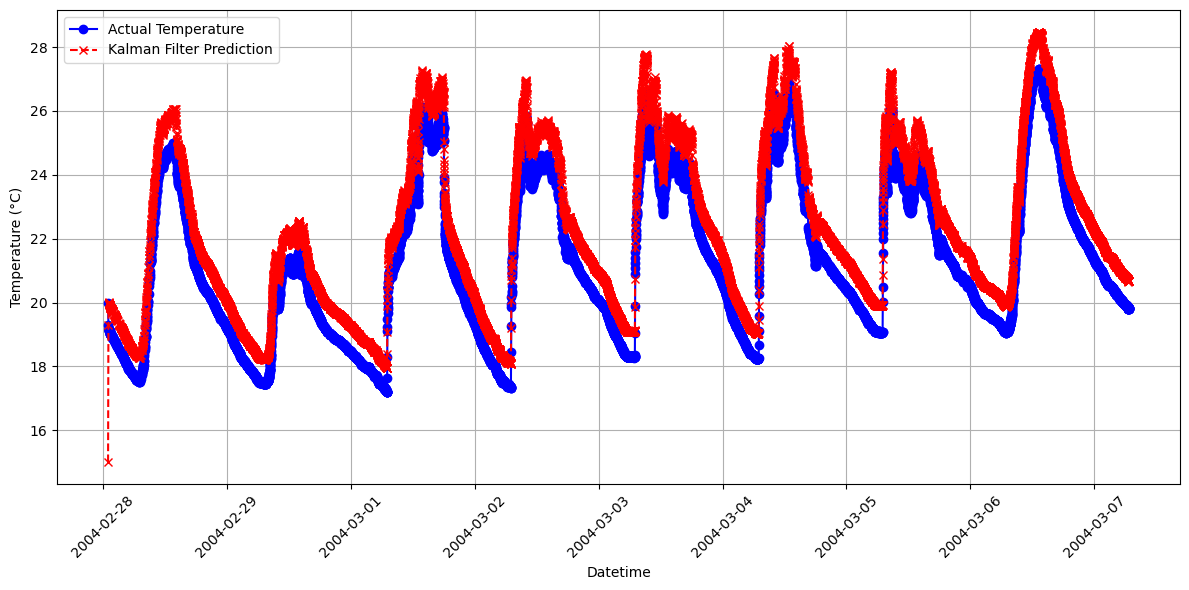

Average MSE: 0.8842699469310601


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 3050 rows
top_150_df = df.head(15050)

# Parameters
A = 23      # State transition matrix
H = 1       # Measurement matrix
Q = 0       # Process noise covariance
R = 0.01       # Measurement noise covariance
x_hat = 15  # Initial state estimate (initial temperature)
P = 1      # Initial estimate covariance

# Kalman Filter Implementation
estimated = np.zeros(len(top_150_df))
estimated[0] = x_hat

# Store the timestamps for plotting
timestamps = top_150_df['datetime'].values

# Apply the Kalman filter to the temperature readings
for i in range(1, len(top_150_df)):
    # Current measurement
    z = top_150_df['temperature'].iloc[i]

    # Prediction
    xp = A * x_hat
    Pp = A * P * A + Q

    # Update
    K = Pp * H / (H * Pp * H + R)
    x_hat = xp + K * (z - H * xp)
    P = Pp - K * H * Pp

    # Store the estimate
    estimated[i] = x_hat

# Plot the actual temperature and the Kalman filter predictions
plt.figure(figsize=(12, 6))
plt.plot(timestamps, top_150_df['temperature'], label='Actual Temperature', marker='o', linestyle='-', color='blue')
plt.plot(timestamps, estimated, label='Kalman Filter Prediction', marker='x', linestyle='--', color='red')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print the Mean Squared Error (MSE)
mse = np.mean((top_150_df['temperature'].values - estimated) ** 2)
print(f'Average MSE: {mse}')


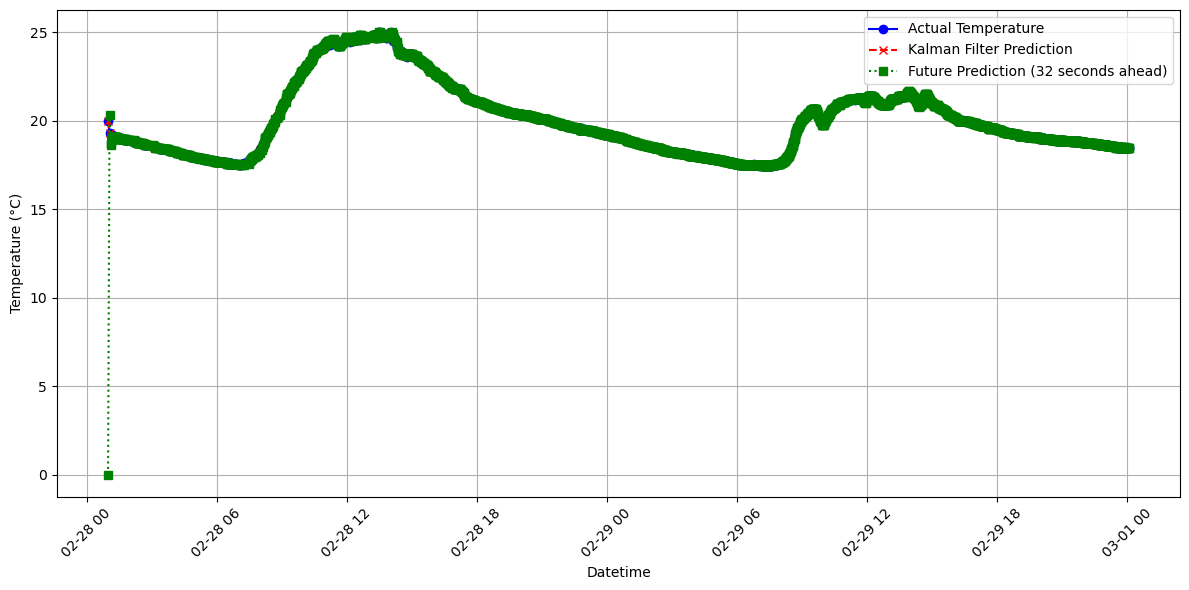

Average MSE: 0.0006193859232487102
Total number of temperature readings: 3049
Number of eventful predictions: 590


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 3050 rows
top_150_df = df.head(3050)

# Parameters
A = np.array([[1, 32], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
x_hat = np.array([[20], [0.01]])      # Initial state estimate (temperature and rate of change)
P = np.eye(2) * 6                     # Initial estimate covariance
epsilon = 0.01                        # Sensitivity threshold for event detection

# Kalman Filter Implementation
estimated = np.zeros((len(top_150_df), 2))
predicted_future = np.zeros((len(top_150_df), 2))
estimated[0] = x_hat.flatten()

# Store the timestamps for plotting
timestamps = top_150_df['datetime'].values

# Initialize counters
total_readings = 0
eventful_readings = 0

# Apply the Kalman filter to the temperature readings
for i in range(1, len(top_150_df)):
    # Current measurement
    z = np.array([[top_150_df['temperature'].iloc[i]]])

    # Prediction
    xp = A @ x_hat
    Pp = A @ P @ A.T + Q

    # Store the future prediction
    predicted_future[i] = xp.flatten()

    # Update
    K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
    x_hat = xp + K @ (z - H @ xp)
    P = Pp - K @ H @ Pp

    # Store the estimate
    estimated[i] = x_hat.flatten()

    # Increment total readings count
    total_readings += 1

    # Check for eventful predictions by comparing future prediction with current estimate
    if abs(predicted_future[i][0] - estimated[i][0]) > epsilon:
        eventful_readings += 1

# Plot the actual temperature, the Kalman filter predictions, and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(timestamps, top_150_df['temperature'], label='Actual Temperature', marker='o', linestyle='-', color='blue')
plt.plot(timestamps, estimated[:, 0], label='Kalman Filter Prediction', marker='x', linestyle='--', color='red')
plt.plot(timestamps, predicted_future[:, 0], label='Future Prediction (32 seconds ahead)', marker='s', linestyle=':', color='green')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print the Mean Squared Error (MSE)
mse = np.mean((top_150_df['temperature'].values - estimated[:, 0]) ** 2)
print(f'Average MSE: {mse}')

# Print the total number of temperature readings and the number of eventful predictions
print("Total number of temperature readings:", total_readings)
print("Number of eventful predictions:", eventful_readings)


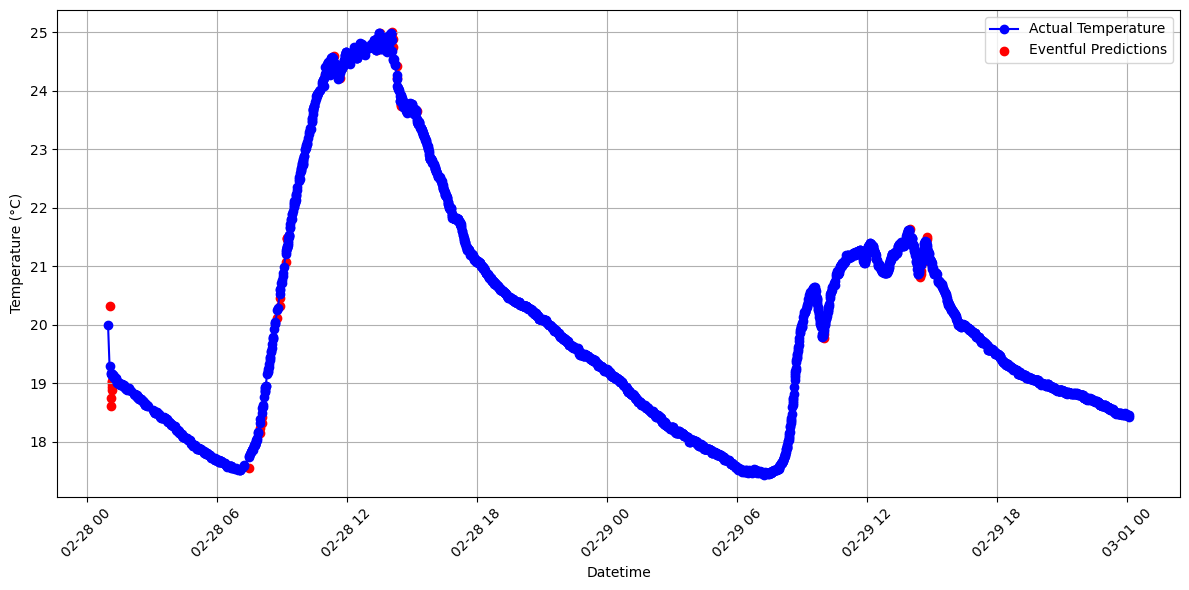

Total number of temperature readings: 3049
Number of eventful predictions: 53


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 3050 rows
top_150_df = df.head(3050)

# Parameters
A = np.array([[1, 32], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
x_hat = np.array([[20], [0.01]])      # Initial state estimate (temperature and rate of change)
P = np.eye(2) * 6                     # Initial estimate covariance
epsilon = 0.04                        # Sensitivity threshold for event detection

# Kalman Filter Implementation
estimated = np.zeros((len(top_150_df), 2))
eventful_predictions = []
eventful_timestamps = []
estimated[0] = x_hat.flatten()

# Store the timestamps for plotting
timestamps = top_150_df['datetime'].values

# Initialize counters
total_readings = 0
eventful_readings = 0

# Apply the Kalman filter to the temperature readings
for i in range(1, len(top_150_df)):
    # Current measurement
    z = np.array([[top_150_df['temperature'].iloc[i]]])

    # Prediction
    xp = A @ x_hat
    Pp = A @ P @ A.T + Q

    # Update
    K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
    x_hat = xp + K @ (z - H @ xp)
    P = Pp - K @ H @ Pp

    # Store the estimate
    estimated[i] = x_hat.flatten()

    # Increment total readings count
    total_readings += 1

    # Check for eventful predictions by comparing future prediction with current estimate
    if abs(xp[0, 0] - estimated[i][0]) > epsilon:
        eventful_readings += 1
        eventful_predictions.append(xp[0, 0])
        eventful_timestamps.append(timestamps[i])

# Plot the actual temperature and eventful predictions
plt.figure(figsize=(12, 6))
plt.plot(timestamps, top_150_df['temperature'], label='Actual Temperature', marker='o', linestyle='-', color='blue')
plt.scatter(eventful_timestamps, eventful_predictions, label='Eventful Predictions', color='red')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Print the total number of temperature readings and the number of eventful predictions
print("Total number of temperature readings:", total_readings)
print("Number of eventful predictions:", eventful_readings)
# Calculate and print the Mean Squared
